# Sax Workshop
> Virtual workshop given for the University of Illinois - 2024.11.14

In [1]:
import sys
from subprocess import call

if "google.colab" in sys.modules:
    call(["uv", "pip", "install", "--system", "git+https://github.com/flaport/sax-workshop"])  # fmt: skip
    call(["uv", "pip", "install", "--system", "sax<0.14"])  # fmt: skip
    call(["pip", "install", "--use-deprecated=legacy-resolver", "opencv-python-headless==4.8.1.78"])  # fmt: skip

## Scatter *dictionaries*
The core datastructure for specifying scatter parameters in SAX is a dictionary... more specifically a dictionary which maps a port combination (2-tuple) to a scatter parameter (or an array of scatter parameters when considering multiple wavelengths for example). Such a specific dictionary mapping is called ann `SDict` in SAX (`SDict ≈ Dict[Tuple[str,str], float]`).

```
in1          out1
   \        /
    ========
   /        \
in0          out0
```

In [2]:
coupling = 0.5
kappa = coupling**0.5
tau = (1 - coupling) ** 0.5
coupler_dict = {
    ("in0", "out0"): tau,
    ("out0", "in0"): tau,
    ("in0", "out1"): 1j * kappa,
    ("out1", "in0"): 1j * kappa,
    ("in1", "out0"): 1j * kappa,
    ("out0", "in1"): 1j * kappa,
    ("in1", "out1"): tau,
    ("out1", "in1"): tau,
}
coupler_dict

{('in0', 'out0'): 0.7071067811865476,
 ('out0', 'in0'): 0.7071067811865476,
 ('in0', 'out1'): 0.7071067811865476j,
 ('out1', 'in0'): 0.7071067811865476j,
 ('in1', 'out0'): 0.7071067811865476j,
 ('out0', 'in1'): 0.7071067811865476j,
 ('in1', 'out1'): 0.7071067811865476,
 ('out1', 'in1'): 0.7071067811865476}

```{note}
#### Advantages of using a dict as S-Matrix representation
- Inherently sparse (you only specify the non-zero connections)
- Explicit in the ports
```

Obviously, it can still be tedious to specify every port in the circuit manually. SAX therefore offers `sax.reciprocal()`, which auto-fills the reverse connection if the forward connection exist. For example:

In [3]:
import sax

coupler_dict = sax.reciprocal(
    {
        ("in0", "out0"): tau,
        ("in0", "out1"): 1j * kappa,
        ("in1", "out0"): 1j * kappa,
        ("in1", "out1"): tau,
    }
)

coupler_dict

{('in0', 'out0'): 0.7071067811865476,
 ('in0', 'out1'): 0.7071067811865476j,
 ('in1', 'out0'): 0.7071067811865476j,
 ('in1', 'out1'): 0.7071067811865476,
 ('out0', 'in0'): 0.7071067811865476,
 ('out1', 'in0'): 0.7071067811865476j,
 ('out0', 'in1'): 0.7071067811865476j,
 ('out1', 'in1'): 0.7071067811865476}

## A first Model: the coupler

Constructing such an `SDict` is easy, however, usually we're more interested in having parametrized models for our components. To parametrize the coupler `SDict`, just wrap it in a keyword-only function:

In [4]:
def coupler(coupling=0.5) -> sax.SDict:
    kappa = coupling**0.5
    tau = (1 - coupling) ** 0.5
    coupler_dict = sax.reciprocal(
        {
            ("in0", "out0"): tau,
            ("in0", "out1"): 1j * kappa,
            ("in1", "out0"): 1j * kappa,
            ("in1", "out1"): tau,
        }
    )
    return coupler_dict


coupler(coupling=0.3)

{('in0', 'out0'): 0.8366600265340756,
 ('in0', 'out1'): 0.5477225575051661j,
 ('in1', 'out0'): 0.5477225575051661j,
 ('in1', 'out1'): 0.8366600265340756,
 ('out0', 'in0'): 0.8366600265340756,
 ('out1', 'in0'): 0.5477225575051661j,
 ('out0', 'in1'): 0.5477225575051661j,
 ('out1', 'in1'): 0.8366600265340756}

We just created a perfect coupler with a varying coupling ratio.

## A second model: the straight waveguide

In [5]:
import jax.numpy as jnp  # JAX-version of numpy


def waveguide(wl=1.55, wl0=1.55, neff=2.34, ng=3.4, length=10.0, loss=0.0) -> sax.SDict:
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    sdict = sax.reciprocal(
        {
            ("in0", "out0"): transmission,
        }
    )
    return sdict

That's pretty straightforward. Let's now move on to parametrized circuits:

## A first circuit: the simple mzi

Existing models can now be combined into a circuit using `sax.circuit`.

In [6]:
mzi, info = sax.circuit(
    netlist={
        "instances": {
            # use the model as-is:
            "lft": "coupler",
            # bake in default values for the models:
            "top": {"component": "waveguide", "settings": {"length": 25.0}},
            "btm": {"component": "waveguide", "settings": {"length": 15.0}},
            "rgt": {"component": "coupler", "settings": {"coupling": 0.5}},
        },
        "connections": {
            "lft,out0": "btm,in0",
            "btm,out0": "rgt,in0",
            "lft,out1": "top,in0",
            "top,out0": "rgt,in1",
        },
        "ports": {
            "in0": "lft,in0",
            "in1": "lft,in1",
            "out0": "rgt,out0",
            "out1": "rgt,out1",
        },
    },
    models={
        "coupler": coupler,
        "waveguide": waveguide,
    },
)

When defining the netlist for the circuit, we can choose to use the model as-is, or to bake-in some default settings. 

Then `sax.circuit()` returns two items: `mzi` and `info`. The first one is the model *function* of the mzi. The second one returns additional info about the circuit (usually you can just ignore this).

Since `mzi` is just a function I should be able to call it:

In [7]:
mzi()  # indeed

{('in0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out0'): Array(-0.28072841+0.10397039j, dtype=complex128),
 ('in0', 'out1'): Array(0.89474612-0.33137758j, dtype=complex128),
 ('in1', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in1', 'out0'): Array(0.89474612-0.33137758j, dtype=complex128),
 ('in1', 'out1'): Array(0.28072841-0.10397039j, dtype=complex128),
 ('out0', 'in0'): Array(-0.28072841+0.10397039j, dtype=complex128),
 ('out0', 'in1'): Array(0.89474612-0.33137758j, dtype=complex128),
 ('out0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'in0'): Array(0.89474612-0.33137758j, dtype=complex128),
 ('out1', 'in1'): Array(0.28072841-0.10397039j, dtype=complex128),
 ('out1', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out1'): Array(0.+0.j, dtype=complex128)}

```{note}
#### Why a function?
You might be wondering... *"why does `sax.circuit()` return a function and not just an S-matrix (or S-dict)?"* The reason for this is that returning a *function* allows you to experiment with changing circuit parameters without having to build the circuit again. This is useful for sweeps, Monte Carlo simulations, optimizations and more
```

Let's have a look at the mzi model parameters

In [8]:
?mzi

Signature:
mzi(
    *,
    lft={'coupling': 0.5},
    top={'wl': 1.55, 'wl0': 1.55, 'neff': 2.34, 'ng': 3.4, 'length': 25.0, 'loss': 0.0},
    btm={'wl': 1.55, 'wl0': 1.55, 'neff': 2.34, 'ng': 3.4, 'length': 15.0, 'loss': 0.0},
    rgt={'coupling': 0.5},
) -> 'SType'
Docstring: <no docstring>
File:      c:\users\flori\projects\sax-workshop\.venv\lib\site-packages\sax\circuit.py
Type:      function

The circuit takes four parameters: `lft`, `top`, `btm` and `rgt`. These are the instance names of our circuit! Moreover - as you can see - each instance name maps to the parameters of the associated model.

This means we could parametrize our mzi as follows:

In [9]:
mzi(lft={"coupling": 0.3}, top={"wl": 1.31}, btm={"wl": 1.31}, rgt={"coupling": 0.3})

{('in0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out0'): Array(-0.39696875-0.32897366j, dtype=complex128),
 ('in0', 'out1'): Array(0.85073721-0.1021682j, dtype=complex128),
 ('in1', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in1', 'out0'): Array(0.85073721-0.1021682j, dtype=complex128),
 ('in1', 'out1'): Array(0.30778904-0.41361065j, dtype=complex128),
 ('out0', 'in0'): Array(-0.39696875-0.32897366j, dtype=complex128),
 ('out0', 'in1'): Array(0.85073721-0.1021682j, dtype=complex128),
 ('out0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'in0'): Array(0.85073721-0.1021682j, dtype=complex128),
 ('out1', 'in1'): Array(0.30778904-0.41361065j, dtype=complex128),
 ('out1', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out1'): Array(0.+0.j, dtype=complex128)}

However, many parameter names and values are repeated. Therefore it's sometimes more useful to call the circuit with globally defined parameters:

In [10]:
mzi(coupling=0.3, wl=1.31)

{('in0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out0'): Array(-0.39696875-0.32897366j, dtype=complex128),
 ('in0', 'out1'): Array(0.85073721-0.1021682j, dtype=complex128),
 ('in1', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in1', 'out0'): Array(0.85073721-0.1021682j, dtype=complex128),
 ('in1', 'out1'): Array(0.30778904-0.41361065j, dtype=complex128),
 ('out0', 'in0'): Array(-0.39696875-0.32897366j, dtype=complex128),
 ('out0', 'in1'): Array(0.85073721-0.1021682j, dtype=complex128),
 ('out0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'in0'): Array(0.85073721-0.1021682j, dtype=complex128),
 ('out1', 'in1'): Array(0.30778904-0.41361065j, dtype=complex128),
 ('out1', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out1'): Array(0.+0.j, dtype=complex128)}

Globally defined parameters will distribute over any child instance parameters if the child model accepts that parameter. In practice globally defined parameters are often used for ambient parameters like wavelength (`wl`) or temperature (`T`).

```{note}
#### Summary
* The `sax.circuit` function just returns another python function as our *model* for the newly created circuit.
* You can 'bake in' default parameters within the netlist
* You can override parameters when calling the circuit function
* You can override parameters globally when calling a circuit function.
```

## A first simulation: wavelength sweep of the simple mzi

You might be tempted to perform a wavelength sweep with a loop:

```{caution}
Don't do this!
```

In [11]:
%%time
S_matrices = []
wls = jnp.linspace(1.5, 1.6, 100)
for wl in wls:
    S = mzi(wl=wl)
    S_matrices.append(S)

CPU times: total: 2.44 s
Wall time: 2.78 s


This is fairly inefficient. Moreover now you're stuck with a list of S-dicts which are pretty hard to merge. In stead, SAX is very good at vectorizing:

In [12]:
%%time
S = mzi(wl=wls)

CPU times: total: 156 ms
Wall time: 661 ms


What's inside this S-dictionary is just an array of S-parameters (one for each wavelength)

In [13]:
abs(S["in0", "out0"])

Array([0.5145554 , 0.55503852, 0.59419548, 0.63194204, 0.66819775,
       0.7028861 , 0.73593466, 0.76727523, 0.7968439 , 0.82458121,
       0.85043223, 0.87434662, 0.89627872, 0.91618762, 0.93403717,
       0.94979605, 0.9634378 , 0.97494078, 0.98428825, 0.9914683 ,
       0.99647386, 0.99930268, 0.99995725, 0.9984448 , 0.99477719,
       0.9889709 , 0.9810469 , 0.97103059, 0.95895169, 0.94484414,
       0.92874602, 0.91069937, 0.89075011, 0.86894788, 0.84534594,
       0.82000096, 0.79297293, 0.76432497, 0.73412317, 0.70243645,
       0.66933635, 0.63489688, 0.59919435, 0.56230716, 0.52431567,
       0.48530196, 0.44534968, 0.40454384, 0.36297067, 0.32071735,
       0.27787192, 0.23452302, 0.19075973, 0.14667141, 0.10234745,
       0.05787718, 0.01334961, 0.03114669, 0.0755238 , 0.1196946 ,
       0.16357294, 0.2070738 , 0.25011345, 0.2926096 , 0.33448156,
       0.37565038, 0.41603898, 0.45557229, 0.49417738, 0.53178357,
       0.56832258, 0.60372859, 0.6379384 , 0.67089147, 0.70253

```{note}
The array of S-parameters does not need to be 1D! It can have however many dimensions as you'd like (e.g. one dimension per process parameter). This will come in handy for Monte Carlo simulations later on.
```

Let's see what this gives:

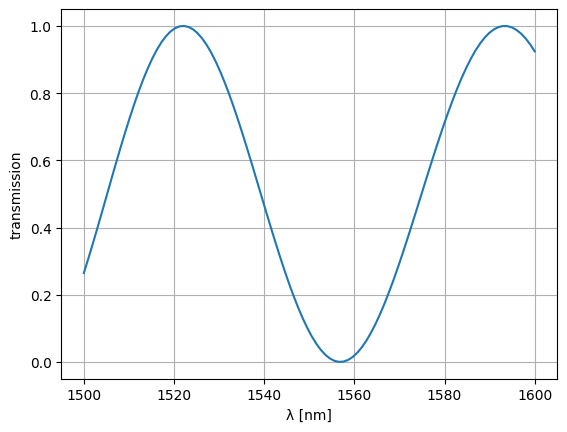

In [14]:
import matplotlib.pyplot as plt

plt.plot(wls * 1e3, abs(S["in0", "out0"]) ** 2)
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [nm]")
plt.ylabel("transmission")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()

## A first layout: MZI with heater

We can quite easily define out own mzi with heater in GDSFactory:

In [15]:
import gdsfactory as gf


@gf.cell()
def mzi_with_heater(
    delta_length=10,
    height=50,
    width=200,
    heater_length=100,
):
    c = gf.Component()
    heater = c.add_ref(
        gf.components.straight_heater_metal(length=heater_length), name="heater"
    )
    heater.dmove(
        heater["o1"].dcenter,
        ((width - heater_length) / 2, height / 2 + delta_length / 2),
    )
    btmwg = c.add_ref(gf.components.straight(length=100), name="btm_straight")
    btmwg.dmove(btmwg["o1"].dcenter, ((width - heater_length) / 2, -height / 2))
    inp = c.add_ref(gf.components.mmi2x2(), name="inp")
    inp.dmove(inp["o3"].dcenter, (0, inp["o2"].dcenter[1]))
    outp = c.add_ref(gf.components.mmi2x2(), name="outp")
    outp.dmove(outp["o1"].dcenter, (width, outp["o1"].dcenter[1]))
    gf.routing.route_single(
        c, port1=inp["o3"], port2=heater["o1"], cross_section="strip"
    )
    gf.routing.route_single(
        c, port1=inp["o4"], port2=btmwg["o1"], cross_section="strip"
    )
    gf.routing.route_single(
        c, port1=outp["o2"], port2=heater["o2"], cross_section="strip"
    )
    gf.routing.route_single(
        c, port1=outp["o1"], port2=btmwg["o2"], cross_section="strip"
    )
    c.add_ports([inp["o1"], inp["o2"], outp["o3"], outp["o4"]])
    return c

2024-11-15 19:24:57.692 | INFO     | gplugins.tidy3d.modes:_data:305 - store data into C:\Users\flori\.gdsfactory\modes\Waveguide_a6883bde0965f80f.npz.
2024-11-15 19:25:03.594 | INFO     | gplugins.tidy3d.modes:_data:305 - store data into C:\Users\flori\.gdsfactory\modes\Waveguide_325636abc34a33bc.npz.
2024-11-15 19:25:09.272 | INFO     | gplugins.tidy3d.modes:_data:305 - store data into C:\Users\flori\.gdsfactory\modes\Waveguide_781b9cc83308774a.npz.
2024-11-15 19:25:15.368 | INFO     | gplugins.tidy3d.modes:_data:305 - store data into C:\Users\flori\.gdsfactory\modes\Waveguide_29fde50d188aecbd.npz.
2024-11-15 19:25:21.522 | INFO     | gplugins.tidy3d.modes:_data:305 - store data into C:\Users\flori\.gdsfactory\modes\Waveguide_6876631e0678ceab.npz.


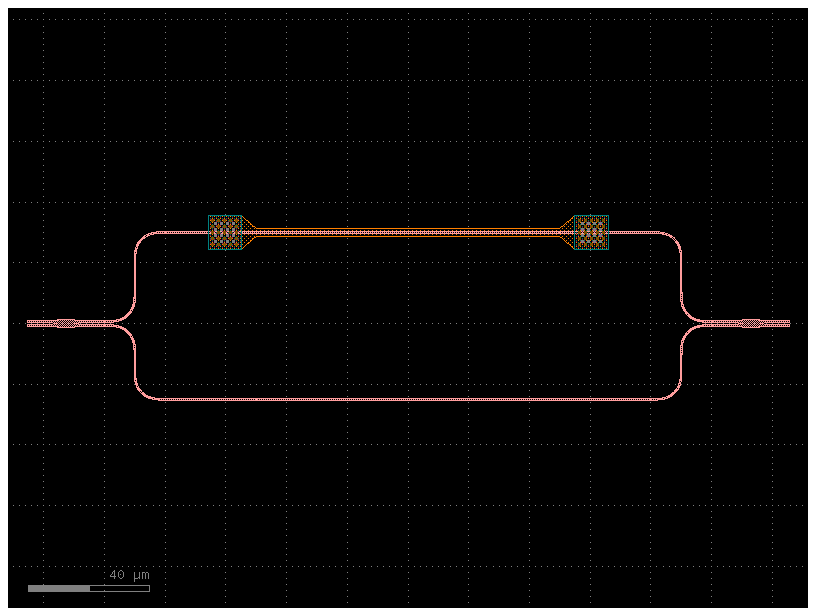

In [16]:
c_mzi1 = mzi_with_heater().dup()
c_mzi1.name = "c_mzi1"  # easier to reference name when working with netlists
c_mzi1

GDSFactory has a built-in way to extract the netlist from a `gf.Component`:

In [17]:
# the recursive=True ensures that *all* netlists are extracted in the case of
# hierarchical components. This is not really relevant here but it's good practice
# to always include it.
netlist = c_mzi1.get_netlist(recursive=True)

This netlist is compatible with SAX. To build our circuit we need to know which models we need:

In [18]:
sax.get_required_circuit_models(netlist)

['bend_euler', 'straight', 'straight_heater_metal_undercut', 'mmi2x2']

Since we now have a layout to go from, let's create some better models for those components first:

## A better waveguide model

We can use some GDSFactory utilities to create a `neff` model for our waveguide

  0%|          | 0/5 [00:00<?, ?it/s]

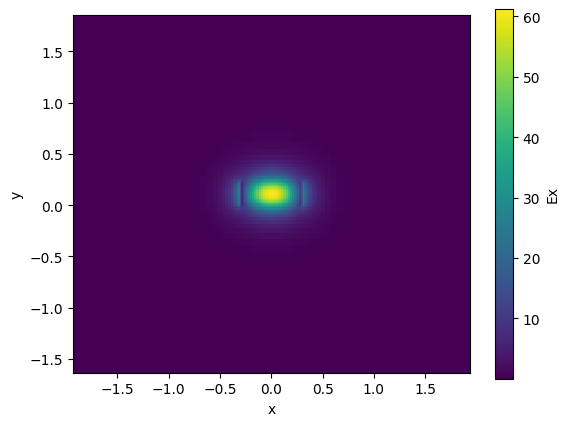

In [19]:
from tqdm.notebook import tqdm
import gplugins.tidy3d as gt

widths = jnp.linspace(0.4, 0.6, 5)
neffs = []
ngs = []
for width in tqdm(widths):
    strip = gt.modes.Waveguide(
        wavelength=1.55,
        core_width=width,
        core_thickness=0.22,
        slab_thickness=0.0,
        core_material="si",
        clad_material="sio2",
        group_index_step=0.01,
    )
    neffs.append(strip.n_eff[0])
    ngs.append(strip.n_group[0])
neffs = jnp.real(jnp.array(neffs))
ngs = jnp.real(jnp.array(ngs))

strip.plot_field(field_name="Ex", mode_index=0)
plt.show()

Now we can create a very basic width v neff model:

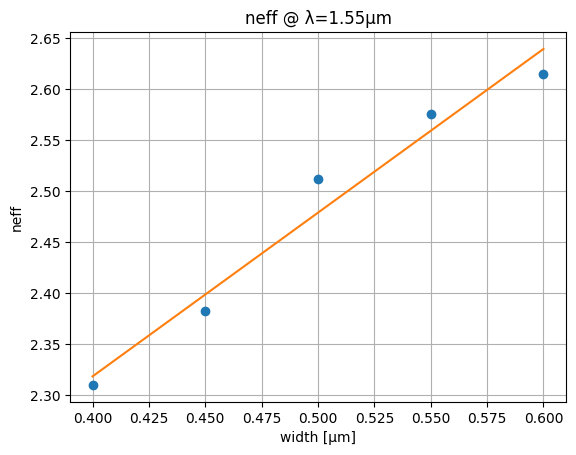

In [20]:
import scipy.stats

m_neff, b_neff, *_ = scipy.stats.linregress(widths, neffs)
plt.plot(widths, neffs, "o")
plt.plot(widths, m_neff * widths + b_neff)
plt.grid(True)
plt.xlabel("width [μm]")
plt.ylabel("neff")
plt.title("neff @ λ=1.55μm")
plt.show()

And a width v ng model:

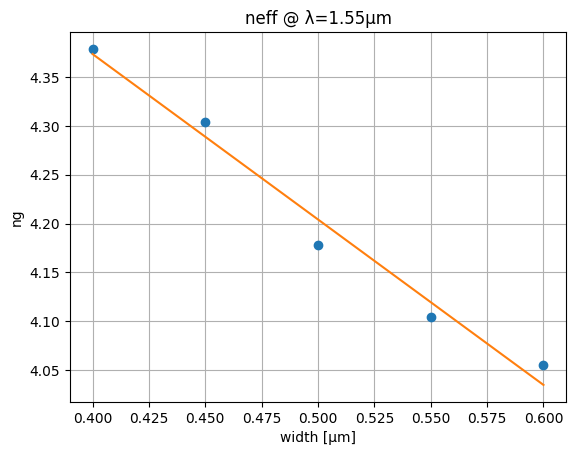

In [21]:
m_ng, b_ng, *_ = scipy.stats.linregress(widths, ngs)
plt.plot(widths, ngs, "o")
plt.plot(widths, m_ng * widths + b_ng)
plt.grid(True)
plt.xlabel("width [μm]")
plt.ylabel("ng")
plt.title("neff @ λ=1.55μm")
plt.show()

```{note}
For actual good models we should do this mode calculation with more accuracy, more width points and probably fit a nonlinear model. However, for this tutorial we just roll with the above...
```

We can now create functions for out fits (valid at wl0=1.5μm)

In [22]:
def neff0(width):
    return m_neff * width + b_neff


def ng0(width):
    return m_ng * width + b_ng

We can combine these two into a single neff function which is valid for a wider wavelength range:

In [23]:
def neff(wl, width):
    wl0 = 1.5
    dwl = wl - wl0
    _neff0 = neff0(width)
    _ng0 = ng0(width)
    dneff_dwl = (_ng0 - _neff0) / wl0
    neff = _neff0 - dwl * dneff_dwl
    return neff

We can plot this as well:

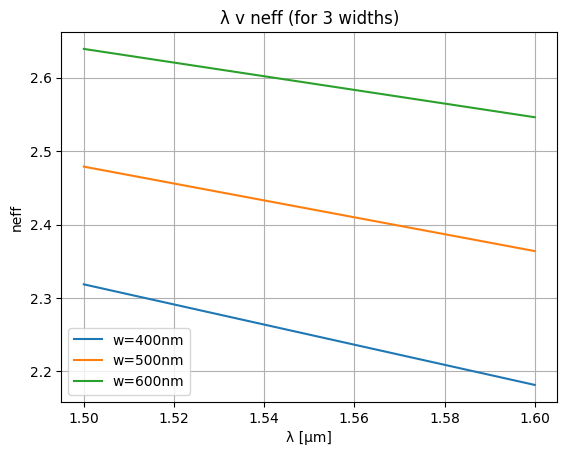

In [24]:
widths = jnp.linspace(0.4, 0.6, 3)
neffs = neff(wls[:, None], widths[None, :])
plt.plot(wls, neffs)
plt.legend([f"w={1e3*w:.0f}nm" for w in widths])
plt.grid(True)
plt.xlabel("λ [μm]")
plt.ylabel("neff")
plt.title("λ v neff (for 3 widths)")
plt.show()

We now have a model for our straight:

In [25]:
def straight(wl=1.55, width=0.5, length=10.0, loss=0.0):
    _neff = neff(wl, width)
    phase = 2 * jnp.pi * _neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    sdict = sax.reciprocal(
        {
            ("o1", "o2"): transmission,
        }
    )
    return sdict

```{note}
The convention in GDSFactory is to have optical ports starting with 'o': o1, o2, ... It's best to define our models with the same convention.
```

## Euler Bend

For this tutorial, let's assume the `bend_euler` is exactly the same as the straight, but with a non-zero loss.

In [26]:
def bend_euler(wl=1.55, width=0.5, length=10.0, loss=0.001):
    return straight(wl=wl, width=width, length=length, loss=loss)

## Heater

A heater is often characterized by its $P_\pi$: the power needed to have a $\pi$ phase shift. For the rest we'll assume the same model as the straight:

In [27]:
def heater(wl=1.55, width=0.5, length=100.0, loss=0.0, P=0.0, Ppi=50):
    wl0 = 1.5
    dn_dP = wl0 / (2 * length * Ppi)
    extra_phase = jnp.exp(2j * jnp.pi * length / wl * dn_dP * P)
    return {
        k: v * extra_phase
        for k, v in straight(wl=wl, width=width, length=length, loss=loss).items()
    }

## MMI2x2

We can propose an MMI model that looks a bit like the following:

In [28]:
from gplugins.sax.models import _mmi_amp


def mmi2x2(wl=1.55) -> sax.SDict:
    wl0 = 1.55
    fwhm = 0.2
    loss_dB = 0.05
    shift = 0.005

    # Convert splitting ratios from power to amplitude by taking the square root
    amplitude_ratio_thru = 0.5**0.5
    amplitude_ratio_cross = 0.5**0.5

    loss_factor_thru = 10 ** (-loss_dB / 20)
    loss_factor_cross = 10 ** (-loss_dB / 20)

    thru = (
        _mmi_amp(wl=wl, wl0=wl0, fwhm=fwhm, loss_dB=loss_dB)
        * amplitude_ratio_thru
        * loss_factor_thru
    )
    cross = (
        1j
        * _mmi_amp(wl=wl, wl0=wl0 + shift, fwhm=fwhm, loss_dB=loss_dB)
        * amplitude_ratio_cross
        * loss_factor_cross
    )

    return sax.reciprocal(
        {
            ("o1", "o3"): thru,
            ("o1", "o4"): cross,
            ("o2", "o3"): cross,
            ("o2", "o4"): thru,
        }
    )

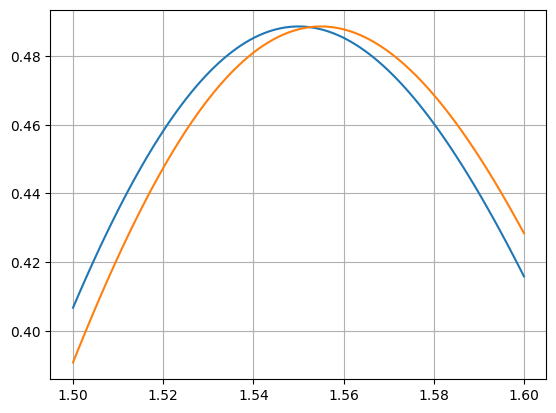

In [29]:
sdict = mmi2x2(wl=wls)
plt.plot(wls, jnp.abs(sdict["o1", "o3"]) ** 2)
plt.plot(wls, jnp.abs(sdict["o2", "o3"]) ** 2)
plt.grid(True)
plt.show()

```{warning}
I once pulled this model out of my hat somewhere because I just wanted something that *kinda* looks like an MMI transfer curve. By now it has found its way into `gplugins` and other places. Please be careful which models you include in your libraries.
```

## Simulate: MZI with heater

Let's have another look at our mzi with heater:

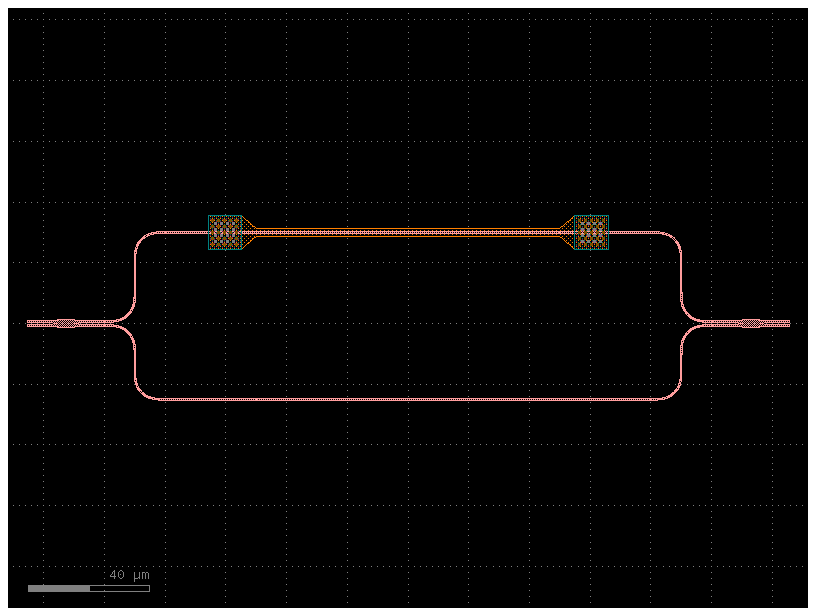

In [30]:
c_mzi1

In [31]:
netlist = c_mzi1.get_netlist()

In [32]:
sax.get_required_circuit_models(netlist)

['bend_euler', 'straight', 'straight_heater_metal_undercut', 'mmi2x2']

We should have all the four models of this circuit. Let's get started.

In [33]:
models = {
    "bend_euler": bend_euler,
    "straight": straight,
    "straight_heater_metal_undercut": heater,
    "mmi2x2": mmi2x2,
}

mzi1, _ = sax.circuit(netlist=netlist, models=models)

We can do an initial plot of this circuit:

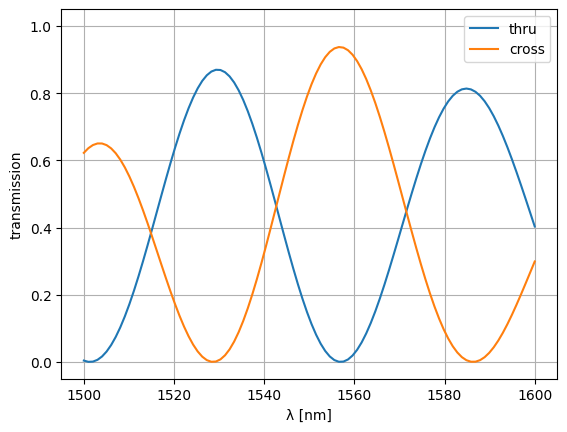

In [34]:
S = mzi1(wl=wls)
plt.plot(wls * 1e3, abs(S["o1", "o3"]) ** 2, label="thru")
plt.plot(wls * 1e3, abs(S["o1", "o4"]) ** 2, label="cross")
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [nm]")
plt.ylabel("transmission")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.show()

## Optimize: MZI with heater

SAX is based on [JAX](https://github.com/jax-ml/jax), a machine learning framework from google. Therefore we can apply all the nice JAX machine learning optimization techniques to optimize our circuit. Let's do a gradient based optimization on the input power of the heater to obtain no cross transmission at λ=1.55μm.

First, let's define a loss function:

In [35]:
import jax


@jax.jit
def loss_fn(P):
    S = mzi1(wl=1.54, heater={"P": P})
    return jnp.abs(S["o1", "o3"])  # cross

From the loss function we can define a gradient function:

In [36]:
grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

```{tip}
Use the `jax.jit` decorator on functions that you expect to run more than once. The first invocation of the decorated function will be slower but after that the execution becomes *blazingly fast*.
```

Next we initialize a JAX optimizer (adam optimizer):

In [37]:
from jax.example_libraries.optimizers import adam

P_init = 0.0
init_fn, update_fn, params_fn = adam(step_size=0.2)
state = init_fn(P_init)

Given all this, a single training step can be defined:

In [38]:
def step_fn(step, state):
    settings = params_fn(state)
    loss = loss_fn(settings)
    grad = grad_fn(settings)
    state = update_fn(step, grad, state)
    return loss, state

And we can use this step function to start the training of the MZI:

In [39]:
from tqdm.notebook import trange

range_ = trange(500)
best_state = state
best_loss = jnp.inf
for step in range_:
    loss, state = step_fn(step, state)
    if loss < best_loss:
        best_loss = loss
        best_state = state
    range_.set_postfix(loss=f"{loss:.6f}")

print(f"{best_loss=}")

  0%|          | 0/500 [00:00<?, ?it/s]

best_loss=Array(3.03502606e-07, dtype=float64)


In [40]:
P = params_fn(state)
P

Array(72.11125256, dtype=float64)

Let's see what we've got over a range of wavelengths:

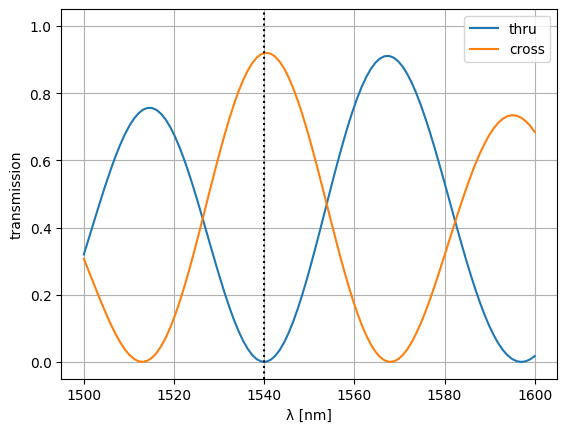

In [41]:
S = mzi1(wl=wls, P=P)
plt.plot(wls * 1e3, abs(S["o1", "o3"]) ** 2, label="thru")
plt.plot(wls * 1e3, abs(S["o1", "o4"]) ** 2, label="cross")
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [nm]")
plt.ylabel("transmission")
plt.axvline(1540, color="black", ls=":")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.show()

```{warning}
Even though we can use all these nice gradient-based optimization techniques from JAX, they might not be the best way to optimize a photonic circuit: it's very easy to get stuck in local minima (try for example optimizing the cross transmission in the above example). It's however very easy to use alternative optimization techniques as well.
```

## Alternative Optimization: optimization of the mzi with heater with scipy.minimize

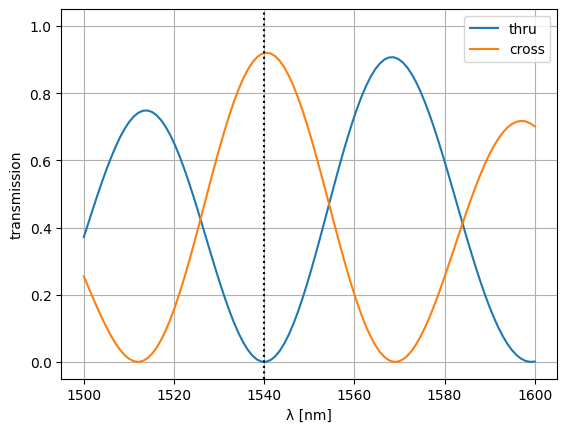

In [42]:
result = scipy.optimize.minimize(loss_fn, (0.0,))

P0 = result.x
S0 = mzi1(wl=wls, P=P0)
plt.plot(wls * 1e3, abs(S0["o1", "o3"]) ** 2, label="thru")
plt.plot(wls * 1e3, abs(S0["o1", "o4"]) ** 2, label="cross")
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [nm]")
plt.ylabel("transmission")
plt.axvline(1540, color="black", ls=":")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.show()

## Monte Carlo Simulation of the MZI

As you probably recall, our waveguide model supports a waveguide width. We can simulate some process variations:

CPU times: total: 797 ms
Wall time: 1.66 s


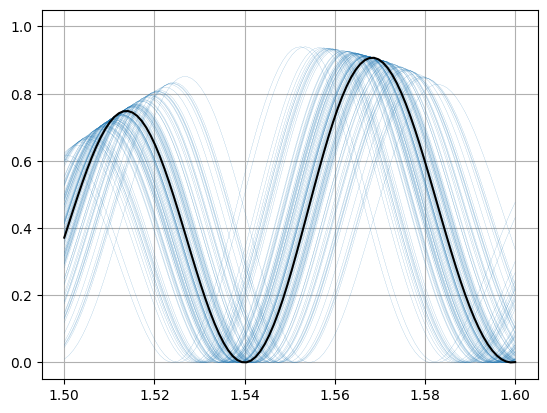

In [43]:
from numpy.random import RandomState

r = RandomState(seed=45)
sigma_width = 0.03 / 3.0  # 3sigma = 30nm
widths = jnp.array(r.randn(100) * sigma_width + 0.5)
%time S = mzi1(wl=wls[:, None], width=widths[None, :], P=P0) # See Extra: broadcasting in python
plt.plot(wls, abs(S["o1", "o3"]) ** 2, color="C0", lw=0.1)
plt.plot(wls, abs(S0["o1", "o3"]) ** 2, color="black")
plt.grid(True)
plt.ylim(-0.05, 1.05)
plt.show()

```{tip}
Did you see what happened there? The mzi1 call *broadcasted* the `mx1` array `wls[:, None]` with the `1xn` array `widths[None, :]` into an Sdict with `mxn` arrays as entries. We basically did two perpendicular parameter sweeps (`wl` and `width`) at once! This is the most efficient way to perform Monte Carlo simulations with SAX. 

To understand more about broadcasting read [the next section](#extra-broadcasting-in-python).
```

# Extra: broadcasting in python

### Indexing with None

The first thing we need to understand is 'indexing with `None`'. This is best explained with an example:

In [44]:
x = jnp.zeros((3, 4))
print(f"{x.shape=}")
print(f"{x[None].shape=}")
print(f"{x[:, None].shape=}")
print(f"{x[:, :, None].shape=}")

x.shape=(3, 4)
x[None].shape=(1, 3, 4)
x[:, None].shape=(3, 1, 4)
x[:, :, None].shape=(3, 4, 1)


Indexing with `None` hence adds an extra dimension at the index location of the `None`. The extra dimension has size 1.

### Broadcasting dimensions with size 1

Dimensions with size 1 can always be *broadcasted* to the size of the matching dimension of another array in the same operation. This is also best explained with an example:

In [45]:
x = jnp.zeros(3)
y = jnp.zeros(4)
print(f"{x.shape=}            | {y.shape=}")
print(f"{x[None, :].shape=} | {y[:, None].shape=}")
print(f"{(x[None, :] + y[:, None]).shape=}")

x.shape=(3,)            | y.shape=(4,)
x[None, :].shape=(1, 3) | y[:, None].shape=(4, 1)
(x[None, :] + y[:, None]).shape=(4, 3)


There is also a `jnp.broadcast_to()` function:

In [46]:
x = jnp.arange(4)
print(f"x={x}")
y = jnp.broadcast_to(x[None, :], (10, 4))
print(f"y={y}")

x=[0 1 2 3]
y=[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]


As you can see, when an array is broadcasted along a dimension with size 1, the array gets repeated along that dimension.

```{note}
broadcasting along a dimension with size bigger than 1 does **not** work.
```

## Hierarchical circuits

You can also simulate hierarchical circuits, such as lattice of MZI interferometers.


In [47]:
@gf.cell
def create_mzis(delta_length1=10, delta_length2=20):
    c = gf.Component()
    c1 = c << mzi_with_heater(delta_length=delta_length1)
    c2 = (c << mzi_with_heater(delta_length=delta_length2)).dmove((400, 200))
    gf.routing.route_single(c, port1=c1["o3"], port2=c2["o1"], cross_section="strip")
    c.add_ports([c1["o1"], c1["o2"], c2["o3"], c2["o4"]])
    return c

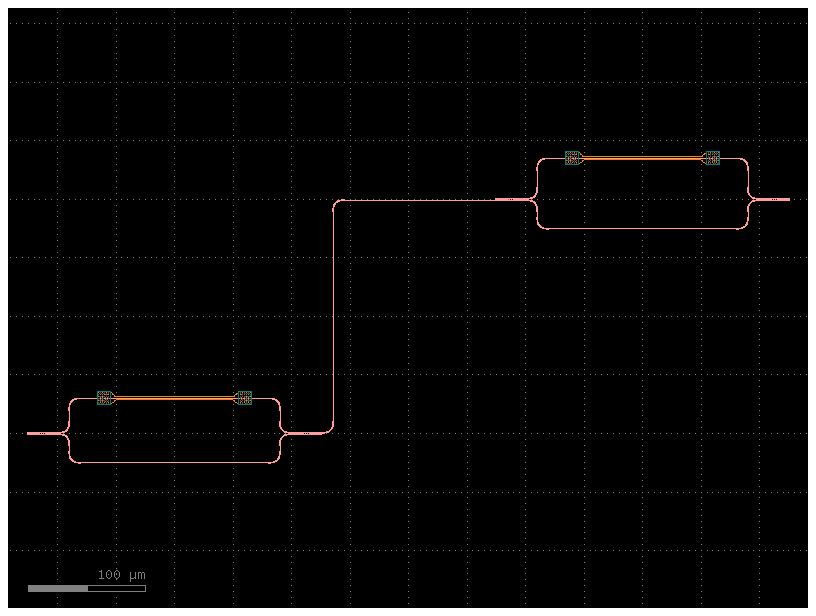

In [48]:
c_mzis = create_mzis()
c_mzis

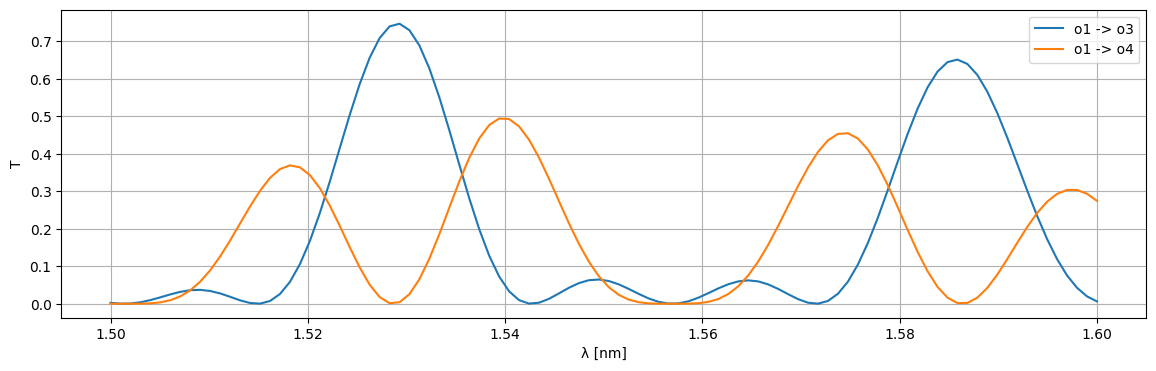

In [49]:
netlist = c_mzis.get_netlist(recursive=True)
mzis, _ = sax.circuit(netlist=netlist, models=models)
S = mzis(wl=wls)

plt.figure(figsize=(14, 4))
plt.plot(wls, jnp.abs(S["o1", "o3"]) ** 2, label="o1 -> o3")
plt.plot(wls, jnp.abs(S["o1", "o4"]) ** 2, label="o1 -> o4")
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.legend()
plt.show()

## Not covered today:

- Multimode simulations
- Alternative backends
- Jitting
- Monte Carlo with wafermaps
- ...